In [2]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.pairs_selection import *
from util.backtest import *
from util.bands import *
from util.pf import round_trips as rt
plt.rcParams["font.family"] = "NanumGothic"
import warnings
warnings.filterwarnings(action='ignore')

import pickle
from pathlib import Path

In [3]:
# Data load
pairs_list = [#('CJ', 'CJ4우(전환)'),
 ('CJ', 'CJ우'),
 ('CJ제일제당', 'CJ제일제당 우'),
 ('DB하이텍', 'DB하이텍1우'),
 #('DL이앤씨', 'DL이앤씨2우(전환)'),
 #('DL이앤씨', 'DL이앤씨우'),
 ('GS', 'GS우'),
 #('JW중외제약', 'JW중외제약2우B'),
 ('JW중외제약', 'JW중외제약우'),
 ('LG', 'LG우'),
 ('LG생활건강', 'LG생활건강우'),
 ('LG전자', 'LG전자우'),
 ('LG화학', 'LG화학우'),
 #('LX하우시스', 'LX하우시스우'),
 ('NH투자증권', 'NH투자증권우'),
 #('SK', 'SK우'),
 ('SK네트웍스', 'SK네트웍스우'),
 ('SK이노베이션', 'SK이노베이션우'),
 ('S-Oil', 'S-Oil우'),
 ('금호석유', '금호석유우'),
 ('넥센타이어', '넥센타이어1우B'),
 ('대상', '대상우'),
 ('대한항공', '대한항공우'),
 #('미래에셋증권', '미래에셋증권2우B'),
 ('미래에셋증권', '미래에셋증권우'),
 ('삼성SDI', '삼성SDI우'),
 #('삼성물산', '삼성물산우B'),
 ('삼성전기', '삼성전기우'),
 ('삼성전자', '삼성전자우'),
 ('삼성화재', '삼성화재우'),
 #('아모레G', '아모레G3우(전환)'),
 ('아모레G', '아모레G우'),
 ('아모레퍼시픽', '아모레퍼시픽우'),
 ('유한양행', '유한양행우'),
 #('하이트진로', '하이트진로2우B'),
 ('한국금융지주', '한국금융지주우'),
 #('한화', '한화3우B'),
 ('한화', '한화우'),
 ('한화솔루션', '한화솔루션우'),
 ('현대건설', '현대건설우'),
 #('현대차', '현대차2우B'),
 #('현대차', '현대차3우B'),
 ('현대차', '현대차우'),
 ('호텔신라', '호텔신라우')]

In [4]:
main_path = '/home/lululalamoon/CHO/chosta/data/k_stocks/daily/ohlcv'
ohlcv_list=[]
price_pairs = []
stock_names = []
for pair in pairs_list:
    for j in pair:
        data = pd.read_csv(main_path + f'/{j}_ohlcv.csv', index_col=0, parse_dates=True)
        ohlcv_list.append(data)
        stock_names.append(j)
ohlcv_dict = dict(zip(stock_names, ohlcv_list))

In [107]:
pairs_list[0]

('CJ', 'CJ우')

In [145]:
trade_dates_all = []
used_pairs_list_all = []


common = pairs_list[0][0]
preferred = pairs_list[0][1]

common = '삼성전자'
preferred = '삼성전자우'

common_price = ohlcv_dict[common]['종가'].rename(common)  # 수정종가 사용
preferred_price = ohlcv_dict[preferred]['종가'].rename(preferred)
pairs_prices = pd.concat([common_price, preferred_price], axis=1)

# get spread
first = pairs_prices.dropna().iloc[:, 0]  # 보통주
second = pairs_prices.dropna().iloc[:, 1]  # 우선주
spread = get_log_spread(first, second)  # lny-lnx

# make bands
window = 20
mult = 2
mult2 = 3
df_bb = bollinger_bands_double(spread, window, mult, mult2).dropna()

sp, lb, ub, ma = df_bb.price, df_bb.lb, df_bb.ub, df_bb.MA
lb2, ub2 = df_bb.lb2, df_bb.ub2

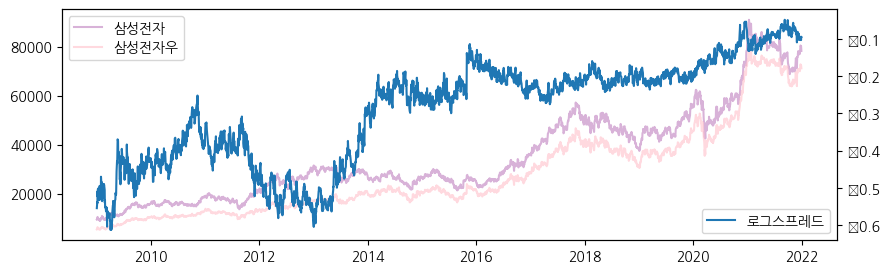

In [146]:
f, ax = plt.subplots(1, figsize=(10,3))
ax.plot(first['2009':'2021'], c='purple',  alpha=0.3)
ax.plot(second['2009':'2021'], c='pink', alpha=0.6)
plt.legend(['삼성전자','삼성전자우'])
ax2 = ax.twinx()
ax2.plot(spread['2009':'2021'])
plt.legend(['로그스프레드'],loc='lower right')
plt.show()

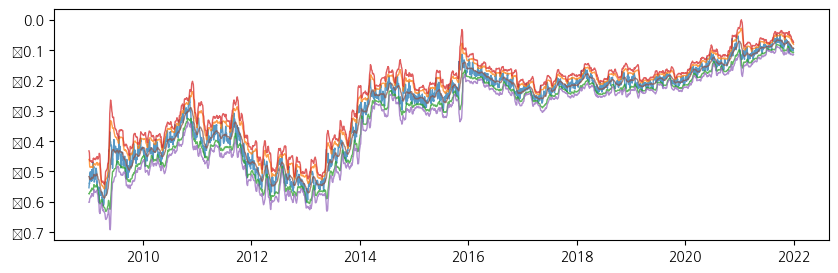

In [147]:
plt.figure(figsize=(10,3))
plt.plot(df_bb['2009':'2021'], alpha=0.75, linewidth=1)
plt.show()

In [148]:
trade_dates = get_trade_dates_bbd_long(sp, ub, lb, ub2, lb2)

#trade_dates = trade_dates[(trade_dates.entry >= start) & (trade_dates.entry < end)].reset_index(drop=True)

In [149]:
entry_spread = df_bb.price.loc[trade_dates.entry]
exit_spread = df_bb.price.loc[trade_dates.exit]

In [163]:
df_bb_samp = df_bb['2009-3':'2021']

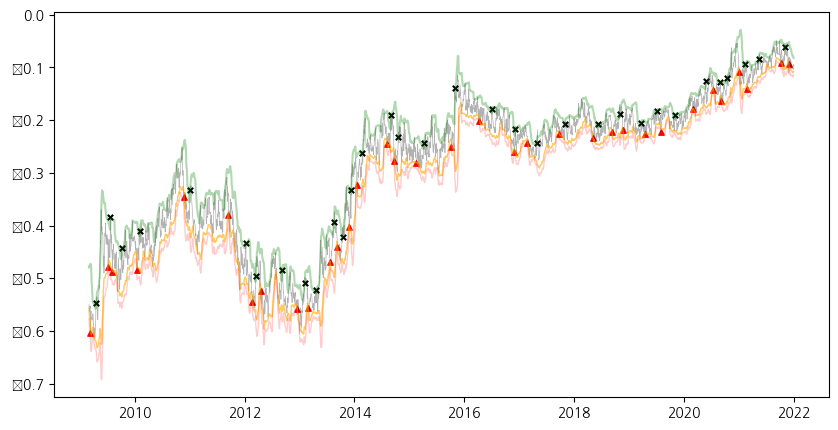

In [164]:
plt.figure(figsize=(10,5))
plt.plot(df_bb_samp.price, c='black', alpha=0.3, linewidth=0.5)
plt.plot(df_bb_samp.lb, c='orange',alpha=0.6, linewidth=1)
plt.plot(df_bb_samp.lb2, c='red', alpha=0.2, linewidth=1)
plt.plot(df_bb_samp.ub, c='green', alpha=0.3)
plt.scatter(entry_spread['2009-3':'2021'].index, entry_spread['2009-3':'2021'], marker='^', c='red', s=15)
plt.scatter(exit_spread['2009-3':'2021'].index, exit_spread['2009-3':'2021'], marker='x',c='black', s=15)
plt.show()

In [165]:
initial_invest = 100_000_000
c = 0.002  # 거래당

In [166]:
transactions_list = []

inventory_now = initial_invest
inventory_history = [inventory_now]

pnl1wc_list  = []
pnl2wc_list  = []

pnl1_list  = []
pnl2_list  = []

In [167]:
trade_dates_samp = trade_dates.loc[trade_dates.entry>'2009-1-1']

In [168]:
for t in trade_dates_samp.index:  # t는 하나의 round-trip
    entry = pd.to_datetime(trade_dates_samp.entry[t])
    exit = pd.to_datetime(trade_dates_samp.exit[t])

    pos = trade_dates_samp.position[t]

    p1_in = first[entry]
    p2_in = second[entry]
    p1_out = first[exit]
    p2_out = second[exit]
    q1 = int(inventory_now / (2 * p1_in))
    q2 = int(inventory_now / (2 * p2_in))

    one_transaction = [[entry, -pos * q1, p1_in, common],
                       [entry, pos * q2, p2_in, preferred],
                       [exit, pos * q1, p1_out, common],
                       [exit, -pos * q2, p2_out, preferred]]
    one_transaction = pd.DataFrame(one_transaction, columns=['index', 'amount', 'price', 'symbol']).set_index(
        'index')

    pnl1_ = (-pos) * (q1 * p1_out - q1 * p1_in)
    cost1_ = c * (q1 * p1_out + q1 * p1_in)
    pnl2_ = pos * (q2 * p2_out - q2 * p2_in)
    cost2_ = c * (q2 * p2_out + q2 * p2_in)

    pnl1 = pnl1_ - cost1_
    pnl2 = pnl2_ - cost2_

    pnl1wc_list.append(pnl1_)
    pnl2wc_list.append(pnl2_)
    pnl1_list.append(pnl1)
    pnl2_list.append(pnl2)
    
    inventory_now += (pnl1 + pnl2)
    inventory_history.append(inventory_now)
    transactions_list.append(one_transaction)

transactions = pd.concat(transactions_list)

In [176]:
t=1 #0부터 시작
transactions_list[t]

,amount,price,symbol
index,,,
2009-07-08,-3923,13100,삼성전자
2009-07-08,6329,8120,삼성전자우
2009-07-23,3923,13560,삼성전자
2009-07-23,-6329,9240,삼성전자우


In [177]:
print('보통주 손익: ', pnl1wc_list[t])
print('우선주 손익: ', pnl2wc_list[t])
print('페어 손익: ', pnl1wc_list[t] + pnl2wc_list[t])

보통주 손익:  -1804580
우선주 손익:  7088480
페어 손익:  5283900


In [178]:
print('보통주 손익 (거래비용 차감): ', pnl1_list[t])
print('우선주 손익 (거래비용 차감): ', pnl2_list[t])
print('페어 손익 (거래비용 차감): ', pnl1_list[t] + pnl2_list[t])

보통주 손익 (거래비용 차감):  -2013754.36
우선주 손익 (거래비용 차감):  6868737.12
페어 손익 (거래비용 차감):  4854982.76


In [179]:
print(f'매매{t+1} 전 Inventory: ', inventory_history[t])
print(f'매매{t+1} 후 Inventory: ', inventory_history[t+1])

매매2 전 Inventory:  102795676.88
매매2 후 Inventory:  107650659.64


In [180]:
ind_ = [list(trade_dates_samp.entry)[0]] + list(trade_dates_samp.exit) # 초기 투자일, 청산일들

In [174]:
inventory = pd.Series(inventory_history, index=pd.to_datetime(ind_))
inventory = inventory.resample('D').last().ffill()
inventory = inventory.to_frame()

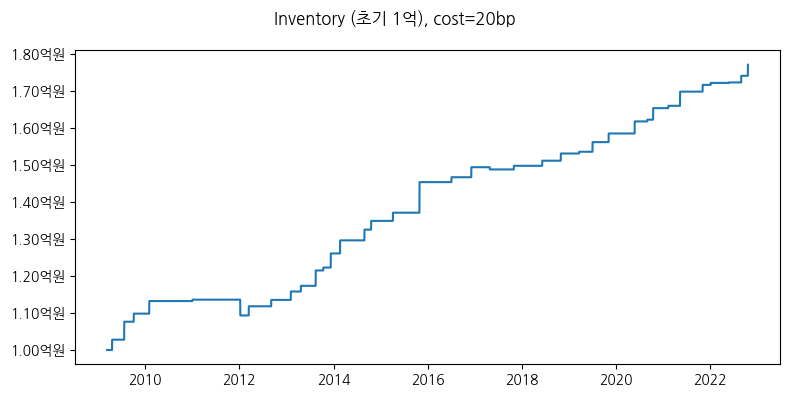

In [175]:
import matplotlib.ticker as ticker
f, ax = plt.subplots(1, figsize=(8, 4))
f.suptitle('Inventory (초기 1억), cost=20bp')

i = inventory[0]
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda i,
                                pos: '{:,.2f}'.format(i / 100_000_000) + '억원'))
ax.plot(i)
f.tight_layout()

plt.show()